In [14]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
train_path = 'data/train'
test_path = 'data/test'

In [3]:
# For training: includes augmentation
train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Because ResNet expects 3-channel input
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor()
])

In [4]:
# For testing: only resize and normalize
test_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [5]:
train_dataset = datasets.ImageFolder(root=train_path, transform=train_transforms)
test_dataset = datasets.ImageFolder(root=test_path, transform=test_transforms)

In [6]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [7]:
print("Class labels:", train_dataset.classes)

Class labels: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [9]:
# Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(train_dataset.classes))  # Assume 7 classes
model = model.to(device)

cuda


C:\Users\kylin\anaconda3\envs\torch-gpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\kylin\anaconda3\envs\torch-gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [11]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss:.4f}, Train Accuracy: {100*correct/total:.2f}%")

Epoch 1/10, Loss: 1044.3106, Train Accuracy: 56.11%
Epoch 2/10, Loss: 892.8910, Train Accuracy: 62.82%
Epoch 3/10, Loss: 834.8568, Train Accuracy: 65.27%
Epoch 4/10, Loss: 788.8945, Train Accuracy: 67.37%
Epoch 5/10, Loss: 751.4154, Train Accuracy: 68.60%
Epoch 6/10, Loss: 717.6225, Train Accuracy: 70.28%
Epoch 7/10, Loss: 676.5208, Train Accuracy: 72.24%
Epoch 8/10, Loss: 653.6091, Train Accuracy: 73.03%
Epoch 9/10, Loss: 621.3344, Train Accuracy: 74.90%
Epoch 10/10, Loss: 594.2630, Train Accuracy: 75.50%


In [12]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Accuracy: {100 * correct / total:.2f}%')

Test Accuracy: 67.89%


In [15]:
# Confusion matrix
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
class_names = train_dataset.classes  

print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[ 626   25   87   16   58  131   15]
 [  18   79    3    1    1    6    3]
 [ 121   10  495   13   70  244   71]
 [  63    6   57 1501   72   46   29]
 [  95    7   50   53  765  251   12]
 [ 126   13  102   30  172  779   25]
 [  24    4  116   35   15    9  628]]


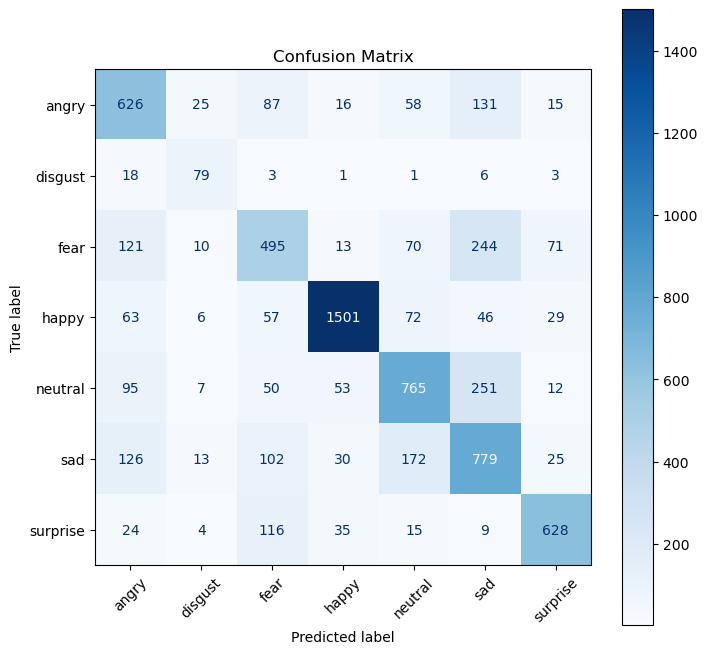

In [16]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# # Transfer learning
# for param in model.parameters():
#     param.requires_grad = False
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.fc.parameters(), lr=0.001)